# Appliances energy prediction Data Set
> dataset can be found here: https://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction

The data set is at 10 min for about 4.5 months. The house temperature and humidity conditions were monitored with a ZigBee wireless sensor network. Each wireless node transmitted the temperature and humidity conditions around 3.3 min. Then, the wireless data was averaged for 10 minutes periods. The energy data was logged every 10 minutes with m-bus energy meters. Weather from the nearest airport weather station (Chievres Airport, Belgium) was downloaded from a public data set from Reliable Prognosis (rp5.ru), and merged together with the experimental data sets using the date and time column. Two random variables have been included in the data set for testing the regression models and to filter out non predictive attributes (parameters).

* **date** time year-month-day hour:minute:second
* **Appliances**, energy use in Wh
* **lights**, energy use of light fixtures in the house in Wh
* **T1**, Temperature in kitchen area, in Celsius
* **RH_1**, Humidity in kitchen area, in %
* **T2**, Temperature in living room area, in Celsius
* **RH_2**, Humidity in living room area, in %
* **T3**, Temperature in laundry room area
* **RH_3**, Humidity in laundry room area, in %
* **T4**, Temperature in office room, in Celsius
* **RH_4**, Humidity in office room, in %
* **T5**, Temperature in bathroom, in Celsius
* **RH_5**, Humidity in bathroom, in %
* **T6**, Temperature outside the building (north side), in Celsius
* **RH_6**, Humidity outside the building (north side), in %
* **T7**, Temperature in ironing room , in Celsius
* **RH_7**, Humidity in ironing room, in %
* **T8**, Temperature in teenager room 2, in Celsius
* **RH_8**, Humidity in teenager room 2, in %
* **T9**, Temperature in parents room, in Celsius
* **RH_9**, Humidity in parents room, in %
* **T_out**, Temperature outside (from Chievres weather station), in Celsius
* **Pressure** (from Chievres weather station), in mm Hg
* **RH_out**, Humidity outside (from Chievres weather station), in %
* **Wind speed** (from Chievres weather station), in m/s
* **Visibility** (from Chievres weather station), in km
* **Tdewpoint** (from Chievres weather station), Â°C
* **rv1**, Random variable 1, nondimensional
* **rv2**, Random variable 2, nondimensional

Where indicated, hourly data (then interpolated) from the nearest airport weather station (Chievres Airport, Belgium) was downloaded from a public data set from Reliable Prognosis, rp5.ru. Permission was obtained from Reliable Prognosis for the distribution of the 4.5 months of weather data.

In [17]:
import pystan
import pandas as pd
import numpy as np
import os
from fbprophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')
%matplotlib inline

In [2]:
df = pd.read_csv('https://s3.amazonaws.com/hackerday.datascience/125/energydata_complete.csv')

In [4]:
pd.set_option('max.columns', None)
df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


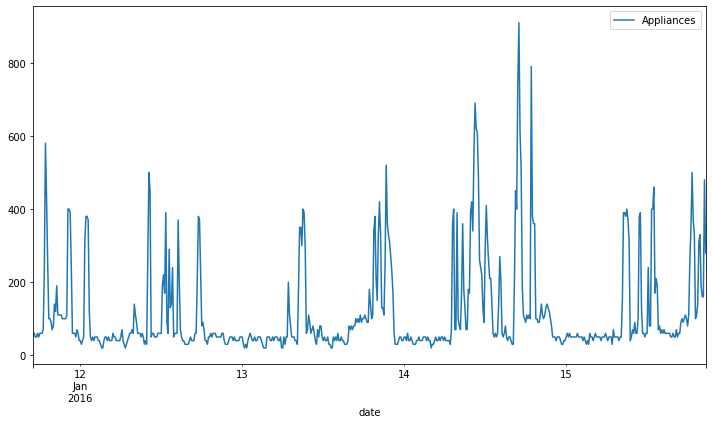

In [18]:
data = df[['date','Appliances']]
data['date'] = pd.to_datetime(data['date'])
data.set_index('date').plot(figsize=(10,6))
plt.tight_layout()

### Features of Prophet
- You can generate hourly, daily, weekly or monthly observations from a few monthly data points.
- Is able to find seasonalities in the data, day of the week or time of the year.
- Can handle outliers and missing values in the data which can be troublesome for usual time series forecasting methods such as ARIMA.
- Able to deal with non-linear trends in the data without the need for exponential smoothing.
- Identifies trend breaks due to hsitorical trend changes due to possible external factors.

### How Prophet works

- Comes with a list of holidays which are known to impact forecasts.
- Gets seasonal dummy variables in advanced.
- Tries to find linear and non-linear trends in the data.
- Uses additive regression model.
- Beta, delta, gamma are used to calculate MAP, Maximum A Posteriori.

>https://facebook.github.io/prophet/docs/quick_start.html

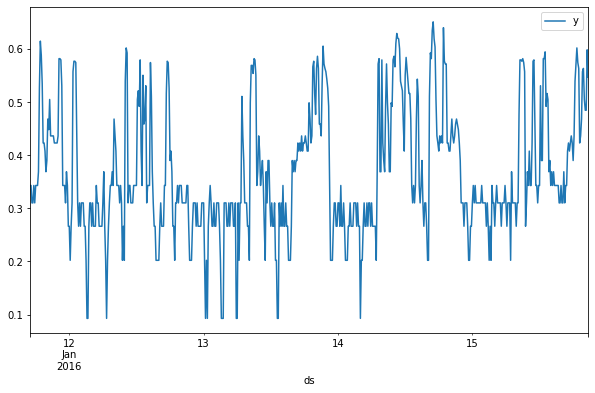

In [22]:
# carrying out a logarithmic transformation on the energy consumption in kw
data.columns = ['ds','y']
data.loc[:,'y'] = np.log(data.loc[:,'y'])
data.set_index('ds').plot(figsize=(10,6))

In [26]:
model = Prophet(weekly_seasonality=True)
model.fit(data)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [27]:
model.params

OrderedDict([('k', array([[0.26012273]])),
             ('m', array([[0.45404193]])),
             ('delta',
              array([[ 2.49408194e-09, -2.15481723e-09,  5.66855455e-10,
                      -8.14374197e-04, -3.25306906e-09, -2.88672593e-09,
                      -1.26471028e-08,  2.13376882e-09, -1.60512860e-09,
                       2.06223374e-09, -4.85993446e-09, -8.73422997e-09,
                      -2.57017580e-09,  1.80442222e-09,  3.75692902e-09,
                       6.63028718e-09, -3.73898795e-09,  1.96000874e-10,
                      -5.64901109e-09,  1.94925630e-09, -3.13026925e-09,
                       9.82637884e-10, -8.26866939e-10,  9.20691687e-09,
                      -5.91897041e-09]])),
             ('sigma_obs', array([[0.14229722]])),
             ('beta',
              array([[-0.03371839, -0.05583444,  0.00337352,  0.00743923,  0.04617282,
                       0.04412593, -0.06528563, -0.05921148, -0.09355899,  0.00308233,
                 

In [29]:
forecast = model.make_future_dataframe(periods=5)
forecast.tail()

,ds
599,2016-01-16 20:40:00
600,2016-01-17 20:40:00
601,2016-01-18 20:40:00
602,2016-01-19 20:40:00
603,2016-01-20 20:40:00


In [30]:
y_preds = model.predict(forecast)

In [31]:
y_preds.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'daily', 'daily_lower', 'daily_upper', 'weekly', 'weekly_lower',
       'weekly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [34]:
y_preds[['ds','yhat']] # predicted consumption

,ds,yhat
0,2016-01-11 17:00:00,0.375315
1,2016-01-11 17:10:00,0.383659
2,2016-01-11 17:20:00,0.392292
3,2016-01-11 17:30:00,0.401089
4,2016-01-11 17:40:00,0.409920
...,...,...
599,2016-01-16 20:40:00,0.635897
600,2016-01-17 20:40:00,0.629536
601,2016-01-18 20:40:00,0.735360
602,2016-01-19 20:40:00,0.669989


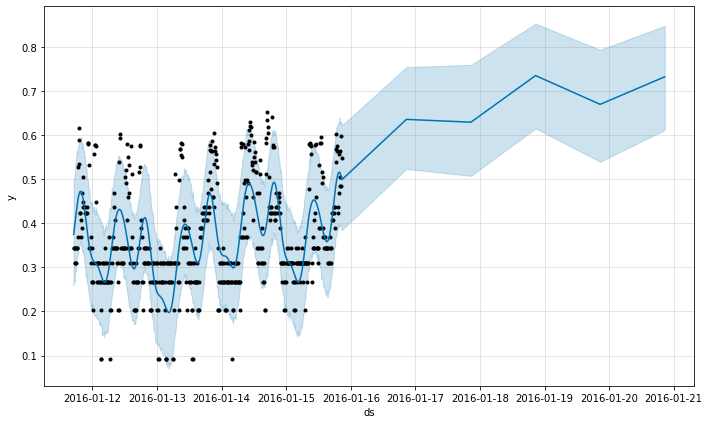

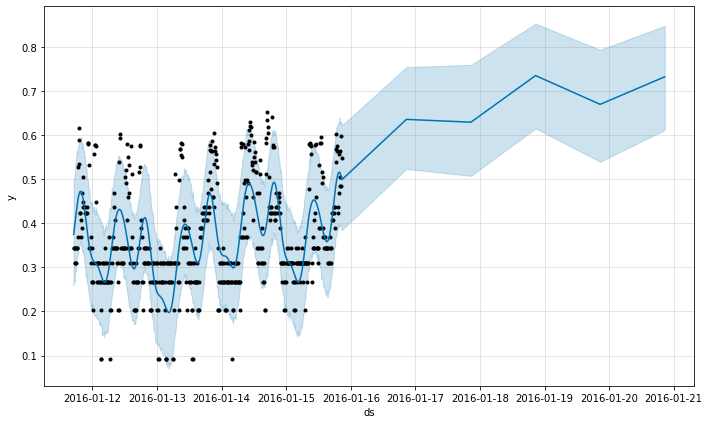

In [35]:
model.plot(y_preds)

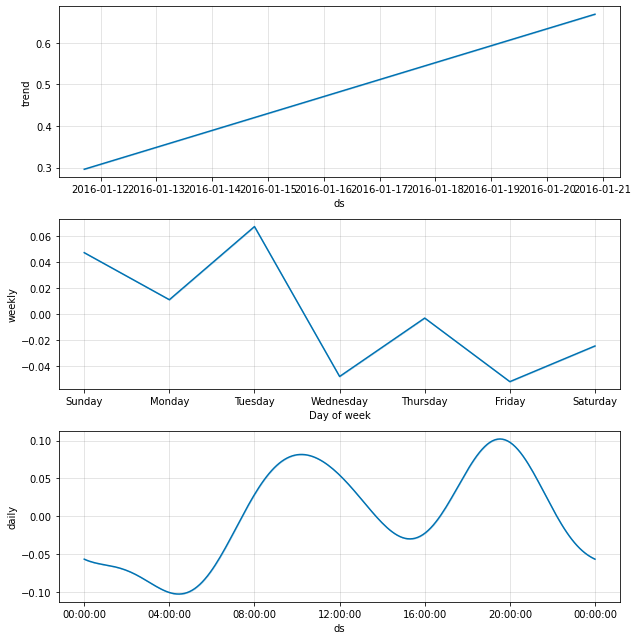

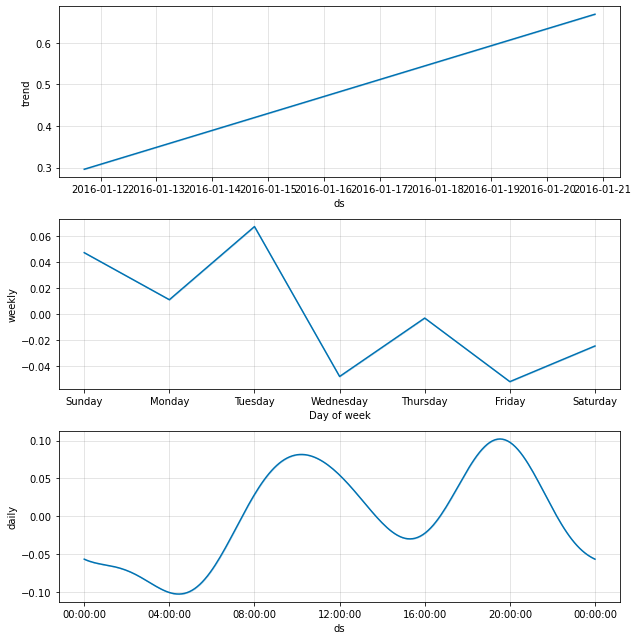

In [36]:
model.plot_components(y_preds)